# Car cost prediction

A company of used cars is developing an application to attract new customers. In it, you can quickly find out the market value of your car. Historical data is at our disposal: technical specifications, complete sets and prices of cars. We need to build a model to predict the cost. 

Important to the customer:

- prediction quality;
- prediction speed;
- training time.

## Data preproccesing

In [1]:
import sys

# Ensuring pip is up to date
!{sys.executable} -m pip install --upgrade pip

# Installing CatBoost using pip with the --user flag
!{sys.executable} -m pip install catboost --user

# Installing lightgbm using pip with the --user flag
!{sys.executable} -m pip install lightgbm --user



In [2]:
!pip install scikit-learn==1.1.3
import re
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
from datetime import datetime
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer


In [3]:
data=pd.read_csv(r'C:\Users\pinos\Downloads\autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
display(data.dtypes)

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
Repaired             object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

There are many string types in the dataset, which suggests that our predictive analysis task will be a regressive classification task, since our goal is the int type.

Looking for duplicates.

In [65]:
data.duplicated().sum()/len(data)*100

21.162403793827256

The number of duplicated files is ridiculous, so we deleted them.

In [7]:
data = data.drop_duplicates()

Now looking for missing values.

In [8]:
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
Repaired             0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Here the amount is quite significant, especially in relation to the repaired, but also in relation to the type of vehicle, and somewhat less in relation to the type of fuel and gearbox.

First, we are going to visualize those variables that will help in forecasting.

In [9]:
len(data['Power'])**0.5/2

297.6428228598835

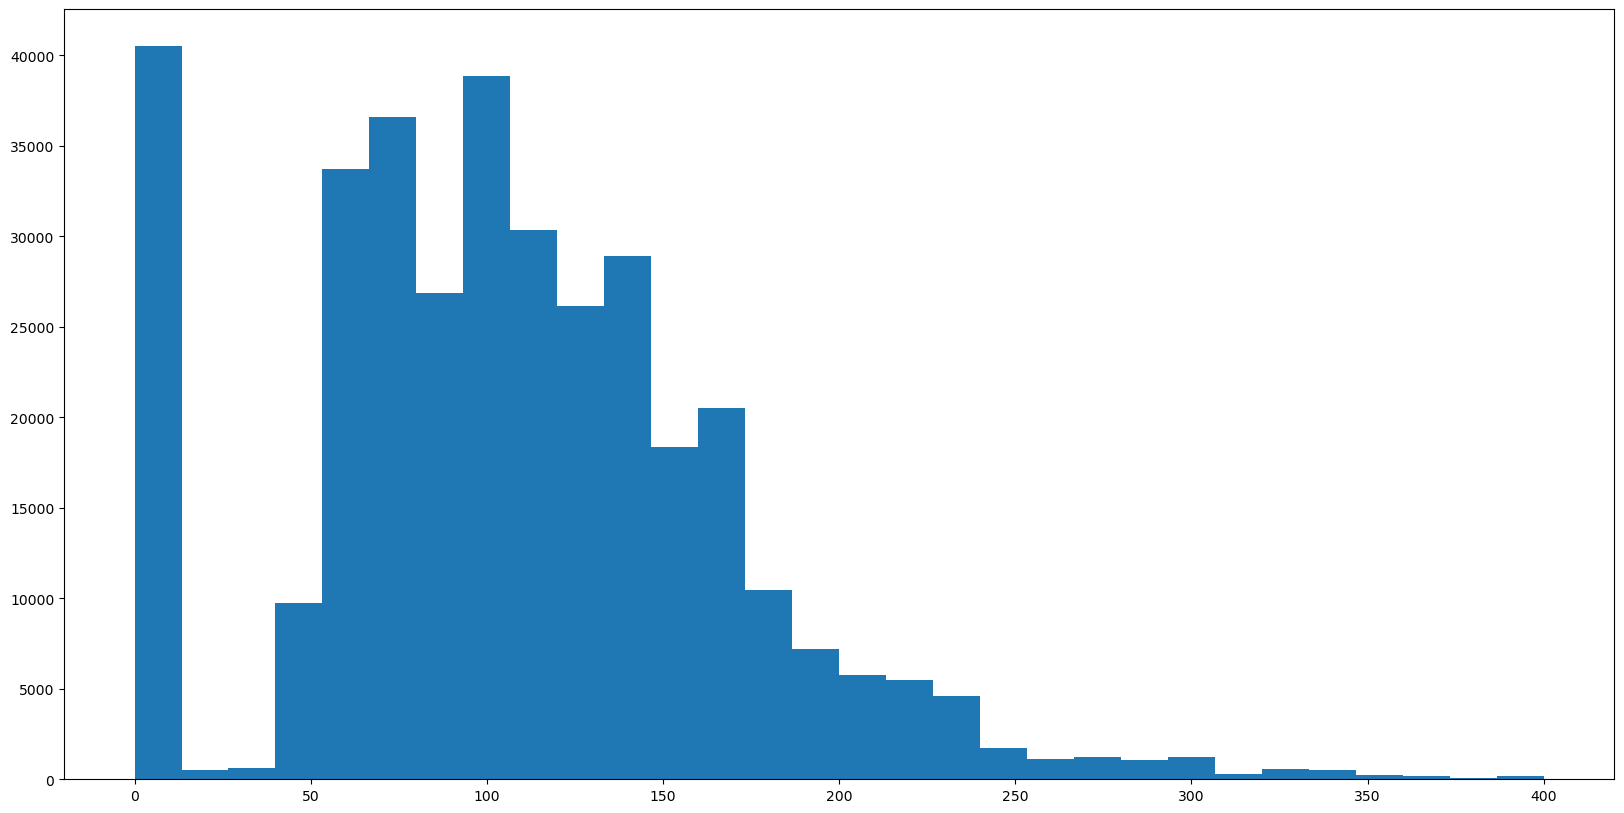

In [10]:
plt.figure(figsize=(20,10))
plt.hist(data['Power'], bins=30, range=(0, 400))
plt.show()

We are amazed by the number of frequencies that we find with zero power, which leads us to believe that this is an error that needs to be fixed by removing them from the dataset. 
In addition, both below 50 and above 300 are atypical values that we can exclude.

In [11]:
data = data.query('Power > 50' and 'Power < 300')

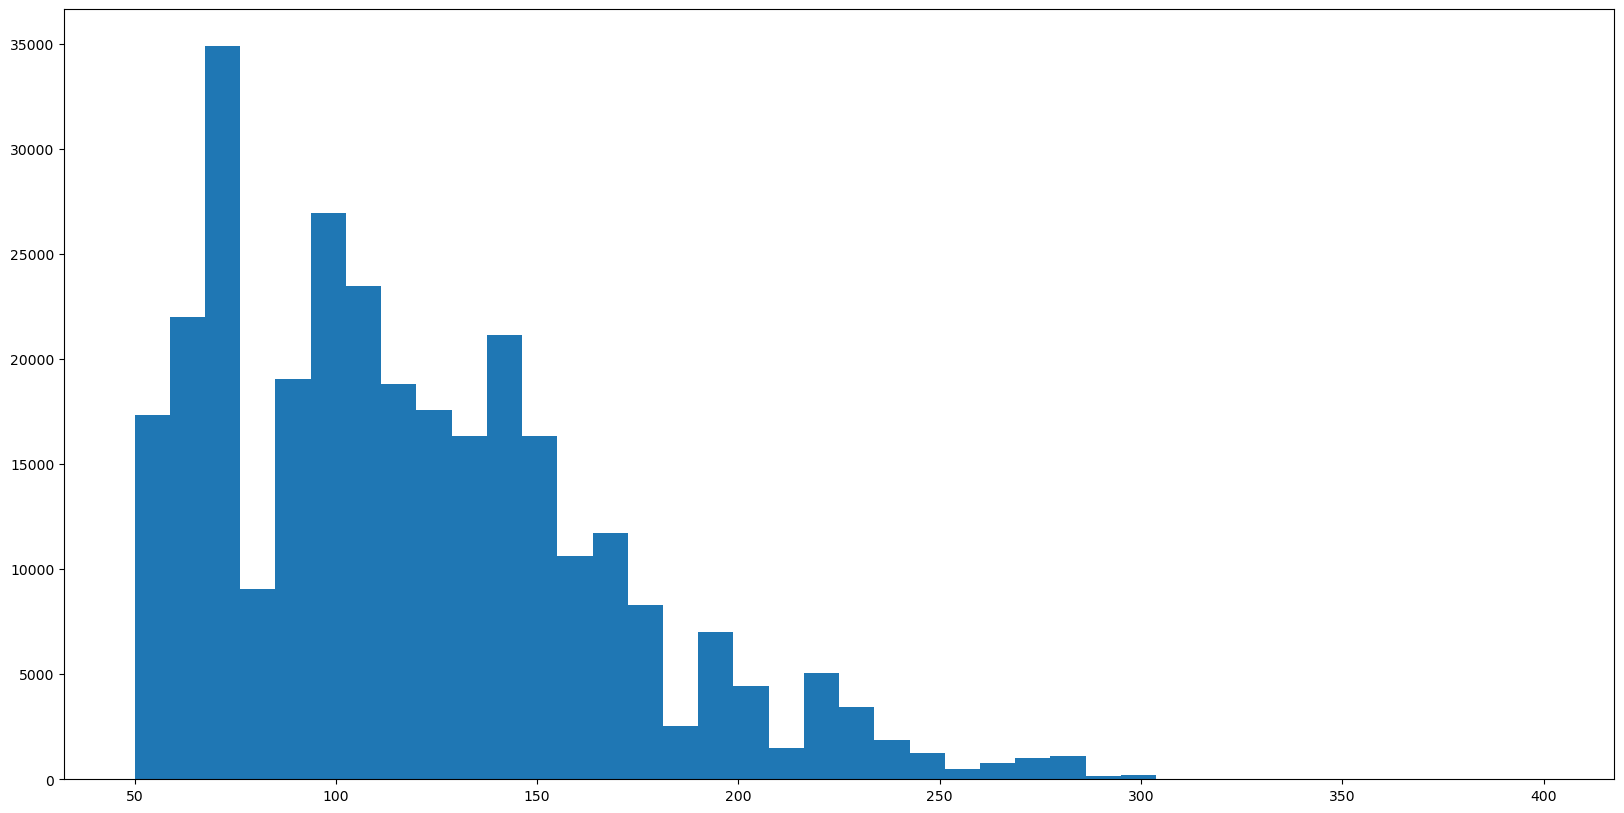

In [12]:
plt.figure(figsize=(20,10))
plt.hist(data['Power'], bins=40, range=(50, 400))
plt.show()

We perform the same operation for the Price variable.

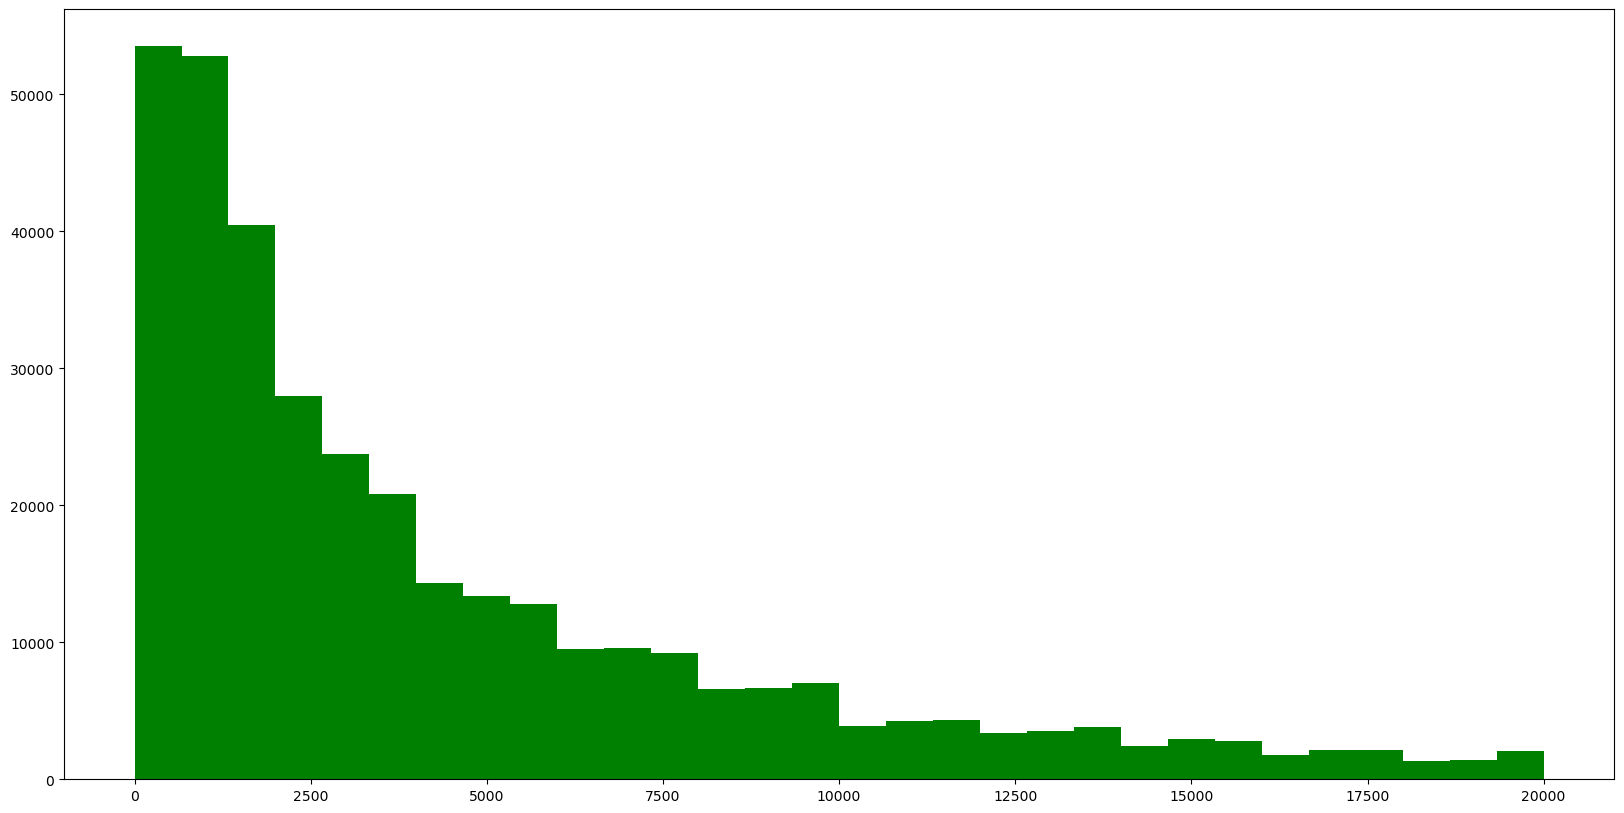

In [13]:
plt.figure(figsize=(20,10))
plt.hist(data['Price'], bins=30, color='green')
plt.show()

In [14]:
data[data['Price'] < 100]['Price'].count()

13171

Below 100 euros, we have almost 7,481 cars, since it is unlikely that a car costs less than 100 euros, we will delete this data.

In [15]:
data=data.query('Price > 100')

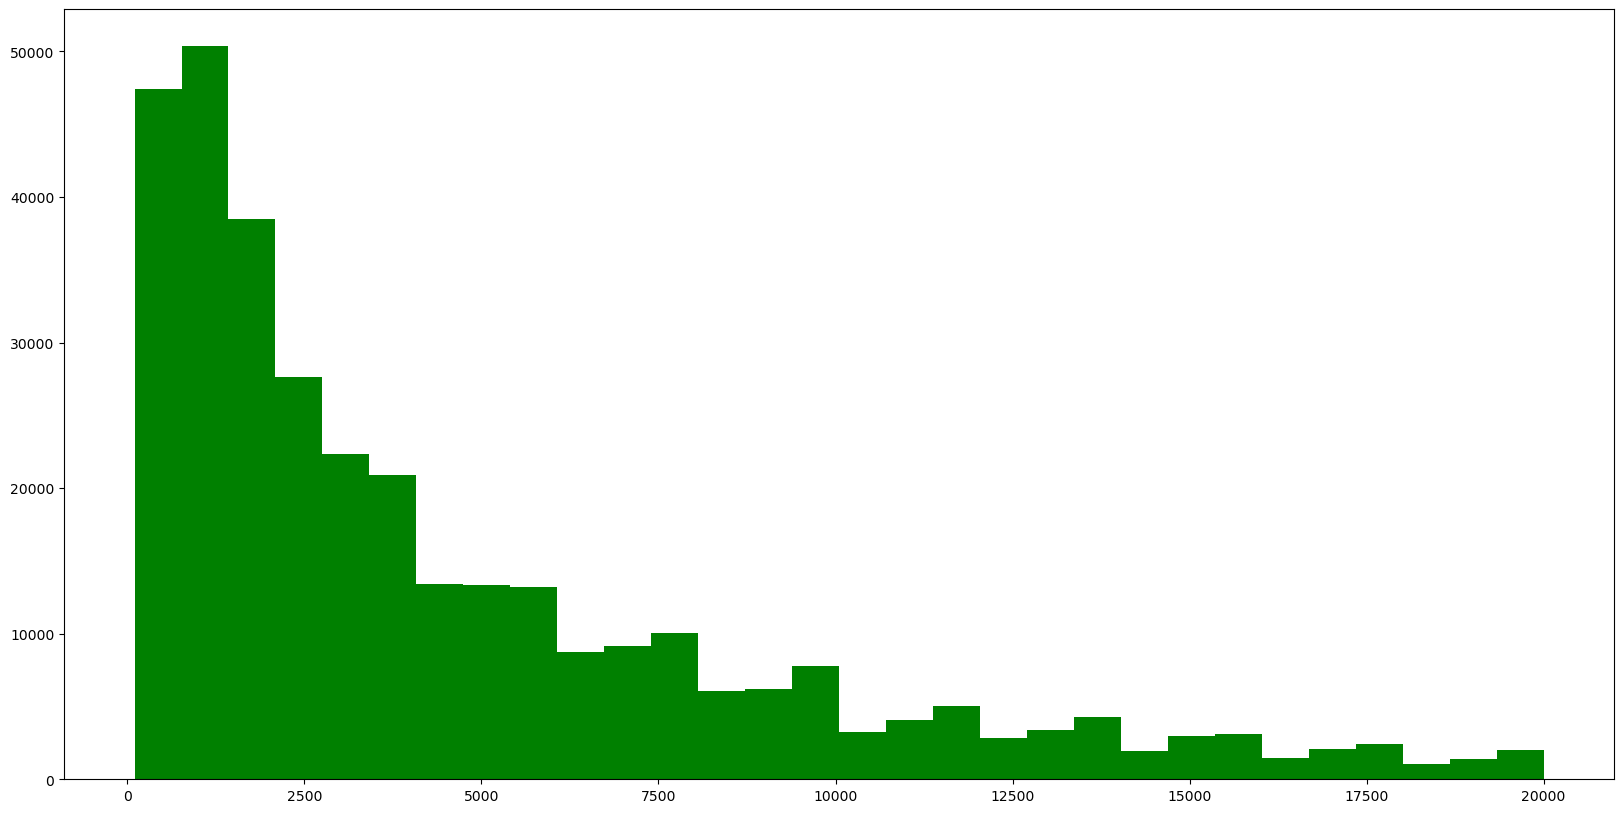

In [16]:
plt.figure(figsize=(20,10))
plt.hist(data['Price'], bins=30, color='green')
plt.show()

We are checking the registration date variable.

In [17]:
print(pd.to_datetime(data['DateCrawled'].min()))
print(pd.to_datetime(data['DateCrawled'].max()))

2016-03-05 14:06:22
2016-04-07 14:36:58


In [18]:
print(pd.to_datetime(data['RegistrationYear'].min()))
print(pd.to_datetime(data['RegistrationYear'].max()))

1970-01-01 00:00:00.000001
1970-01-01 00:00:00.000009999


We filter by the appropriate time parameters.

In [19]:
data = data.query('1970 < RegistrationYear < 2017')

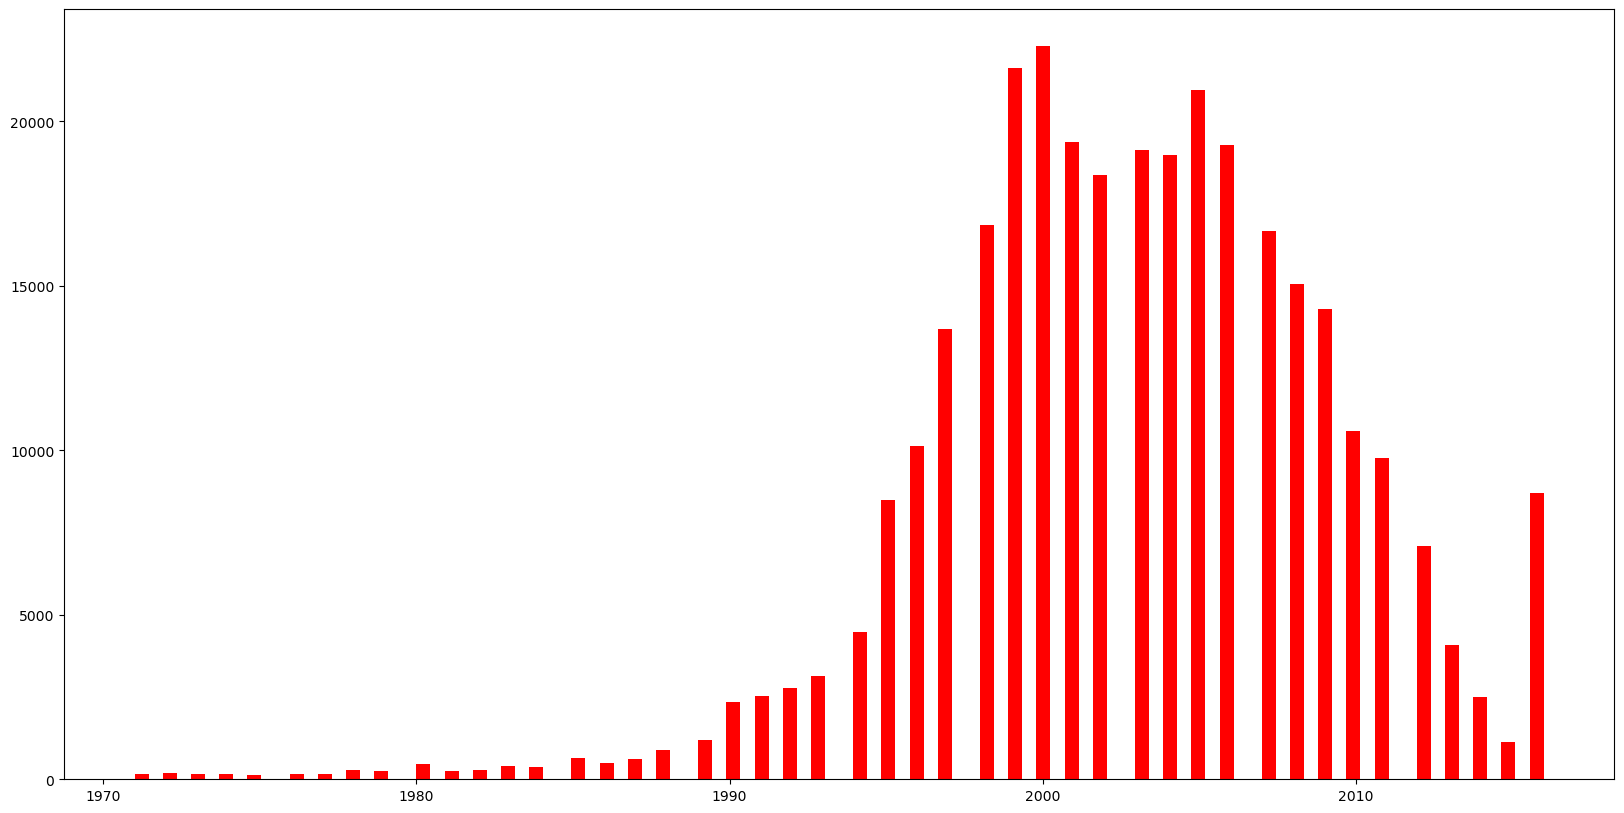

In [20]:
plt.figure(figsize=(20,10))
plt.hist(data['RegistrationYear'], bins=100, color='red')
plt.show()

We are going to fill the remaining nan with an unknown category.

In [21]:
data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']]=data[
    ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']].fillna('unknown')

In [22]:
data.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

Text(0.5, 1.0, 'Correlation Heatmap')

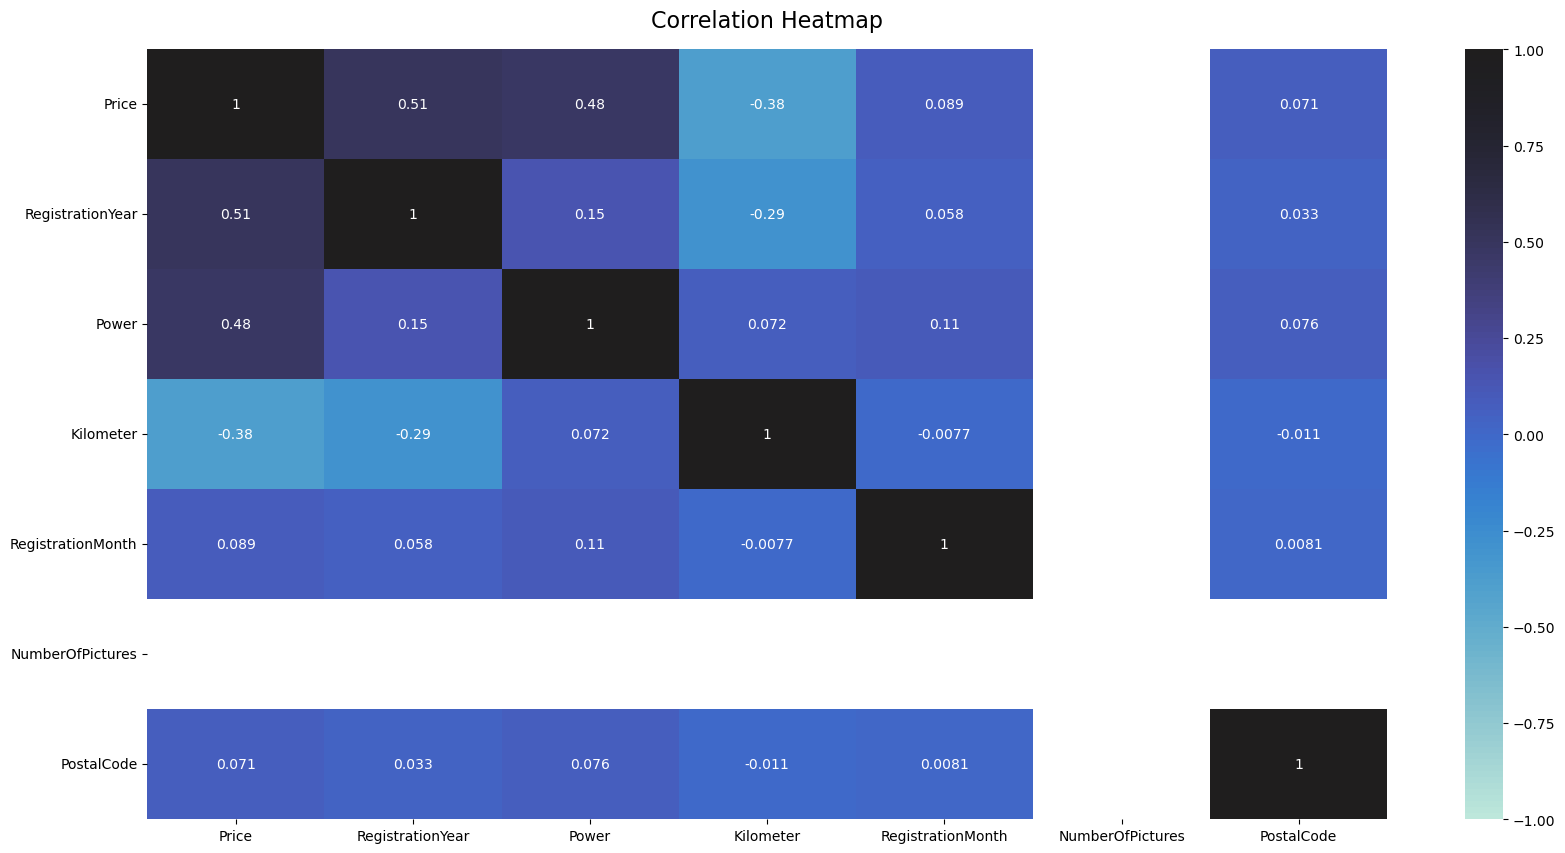

In [23]:
plt.figure(figsize=(20, 10))
h=sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, center=True)
h.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=16)

As we can see in the correlation matrix, the most related variables are Power, Kilometers with Price. these are the variables we dealt with when debugging data.

### Conclusions
In this first section of our research, we got acquainted with our dataset and sorted out the missing data by choosing the best solution: delete the data that we considered an error and fill in the categorical variables with the category unknown.

## Training model

We move on to preparing and splitting the data before applying training and forecasting models.

We have removed the Postal Code column as it is of no value.

In [24]:
data=data.drop(['PostalCode', 'DateCrawled', 'RegistrationMonth', 
                'LastSeen', 'DateCreated', 'NumberOfPictures','RegistrationYear'], axis=1)

In [25]:
data.columns

Index(['Price', 'VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer',
       'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [26]:
data=data.reset_index(drop=True)

In [27]:
data.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no


We have divided our data set into training and test.

In [28]:
target=data['Price']
features=data.drop(['Price'], axis=1)

We perform the function of visualizing real data and forecasts.

In [73]:
def graphics(test,predict):
    MSE = np.square(np.subtract(y_test, predict)).mean() 
    RMSE= math.sqrt(MSE)
    plt.figure(figsize=(20, 10))
    pd.Series(predict).hist(bins=20, alpha=0.7)
    pd.Series(test).hist(bins=20, alpha=0.7)
    plt.text(16122,11225,'MAE={:.2f}'.format(MSE))
    plt.text(16122,10225,'RMSE={:.2f}'.format( RMSE))
    plt.legend(['Predicted values', 'Real values'])
    plt.title('A graph of the distribution of predicted and true values', y=1.05)
    plt.xlabel('Predicted / Real')
    plt.ylabel('Quantity')
    plt.subplot()   
    plt.figure(figsize=(20, 10))
    plt.plot(predict,test,'o', alpha=0.8)
    plt.xlim(-5000,25000)
    plt.ylim(-5000,25000)
    plt.plot([-10000,25000],[-10000,25000],'--y', linewidth=2)
    plt.title('Graph of the ratio of predicted values to true values', y=1.05)
    plt.xlabel('Predicted values')
    plt.ylabel('Real values')
    plt.show()

We process categorical and numerical ones to then create a pipeline that will allow us to train and then predict.

In [30]:
numeric_features = ['Power', 'Kilometer']


In [31]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [32]:
categorical_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

In [33]:
categorical_transformer_forest = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(handle_unknown="error", dtype=np.int8))
      
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer_forest, categorical_features),
    ]
)

In [34]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor(max_depth=2, random_state=42,
                                                                        
                                                                               n_estimators=50))]
)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size = 0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [36]:
param_grid = {
    "regressor__n_estimators": range(10, 60, 10),
    "regressor__max_depth": [None] + [i for i in range(2,11)]
    
}

search_cv = RandomizedSearchCV(clf, param_grid, n_iter=10, random_state=0)
search_cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Power',
                                                                                'Kilometer']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OrdinalEncoder(dtype=<class 'numpy.int8'>))]),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'FuelType',
                                                                                'Brand',
                                                                                'Repaired'])])),
                                             ('regressor',
                                              RandomForestRegressor(max_depth=2,
                                                                    n_estimators=50,
                                                                    random_state=42))]),
                   param_distributions={'regressor__max_depth': [None, 2, 3, 4,
                                                                 5, 6, 7, 8, 9,
                                                                 10],
                                        'regressor__n_estimators': range(10, 60, 10)},
                   random_state=0)

In [37]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__encoder', 'preprocessor__cat__encoder__categories', '

In [66]:
search_cv.fit(X_train, y_train)

print("Best parameters:")
print(search_cv.best_params_)

Best parameters:
{'regressor__n_estimators': 50, 'regressor__max_depth': None}


In [67]:
print(f"CV score: {search_cv.best_score_:.3f}")

CV score: 0.749


In [68]:
print(
    "Accuracy of the best model as a result of randomized search:"
    f"{search_cv.score(X_test, y_test):.3f}"
)

Accuracy of the best model as a result of randomized search:0.752


In [41]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Power', 'Kilometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(dtype=<class 'numpy.int8'>))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=2, n_estimators=50,
                                       random_state=42))])

In [69]:
print("Model evaluation: %.3f" % clf.score(X_val, y_val))

Model evaluation: 0.384


As we can see, the model does not give a good result.

In [43]:
pred_rfr=clf.predict(X_val)

In [44]:
%%time
MSE = np.square(np.subtract(y_val, pred_rfr)).mean() 
RMSE_rfr = math.sqrt(MSE) 
print("RMSE_RandomForestRegressor: ", RMSE_rfr)

RMSE_RandomForestRegressor:  3531.5726582232473
CPU times: total: 0 ns
Wall time: 1.99 ms


In [45]:
random_forest_regressor = [3531, '2.84 ms', '1.75 ms']

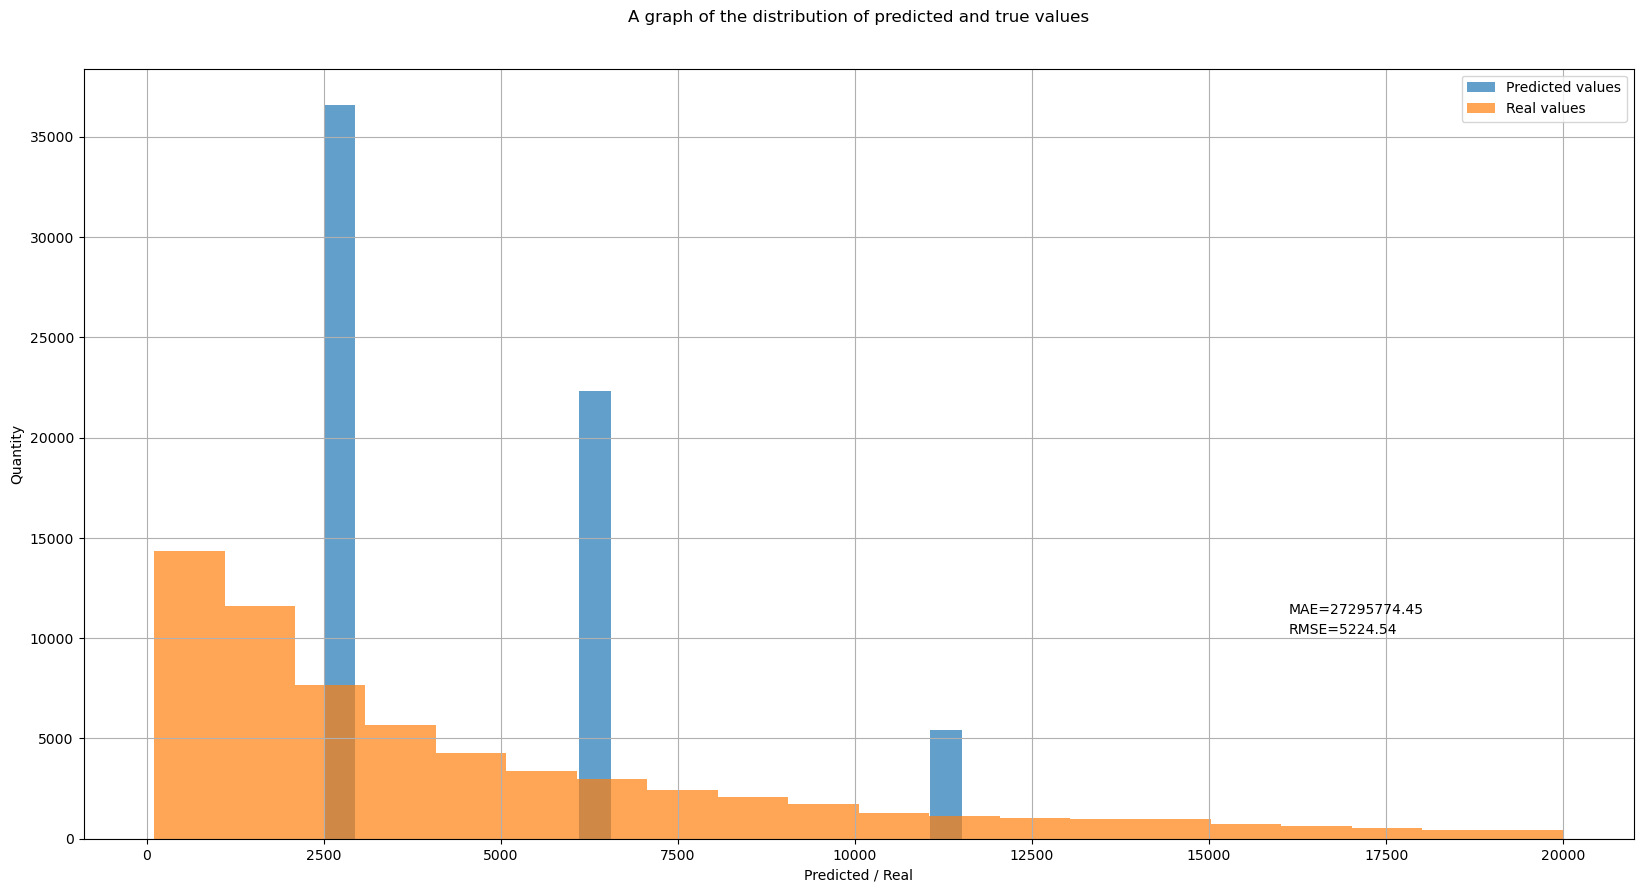

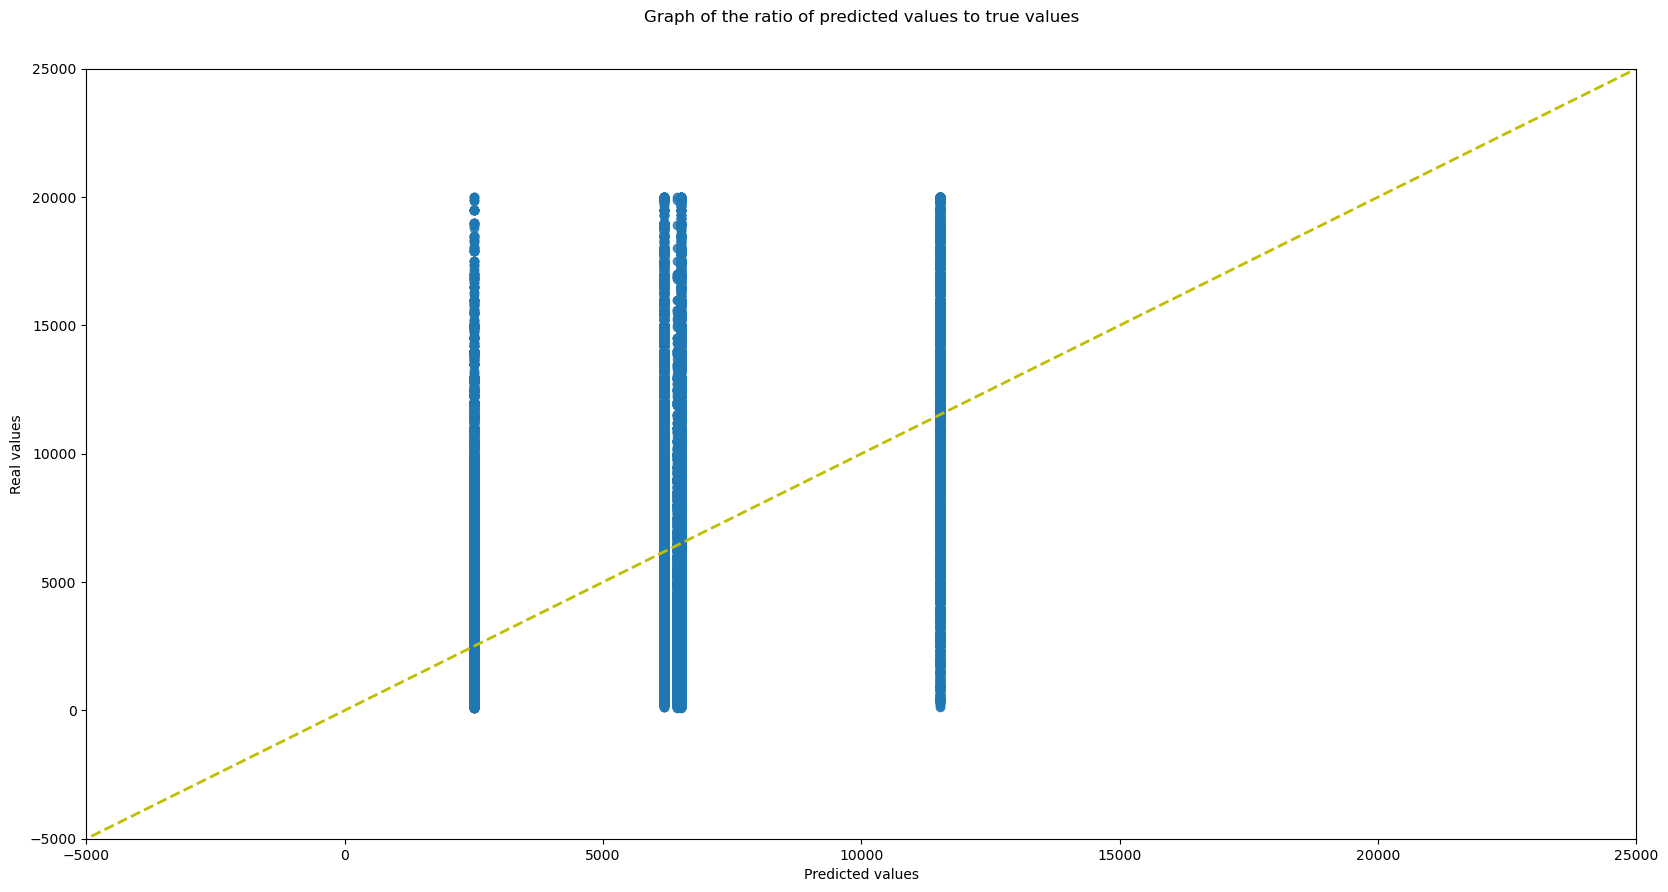

In [74]:
graphics(y_val,pred_rfr)

In [47]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop='first', handle_unknown="ignore", sparse=False, dtype=np.int8))
      
    ]
)

In [48]:
clf_lgbm = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LGBMRegressor(random_state=6))]
)

In [49]:
lgbm_reg_model = clf_lgbm

In [50]:
clf_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 192945, number of used features: 7
[LightGBM] [Info] Start training from score 4571.826676


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Power', 'Kilometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(dtype=<class 'numpy.int8'>))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('regressor', LGBMRegressor(random_state=6))])

In [70]:
print("Model evaluation: %.3f" % clf_lgbm.score(X_val, y_val))

Model evaluation: 0.722


The LGBM model gives twice the best result than the previous one.

In [52]:
pred_lgbm=clf_lgbm.predict(X_val)

In [53]:
%%time
MSE = np.square(np.subtract(y_val, pred_lgbm)).mean() 
RMSE_lgbm = math.sqrt(MSE) 
print("RMSE_LGBM: ", RMSE_lgbm)


RMSE_LGBM:  2370.7756519863074
CPU times: total: 0 ns
Wall time: 997 µs


In [54]:
LGBM = [2370, '15.7 ms', '1.55 ms']

Over time, this also seems like a good option.

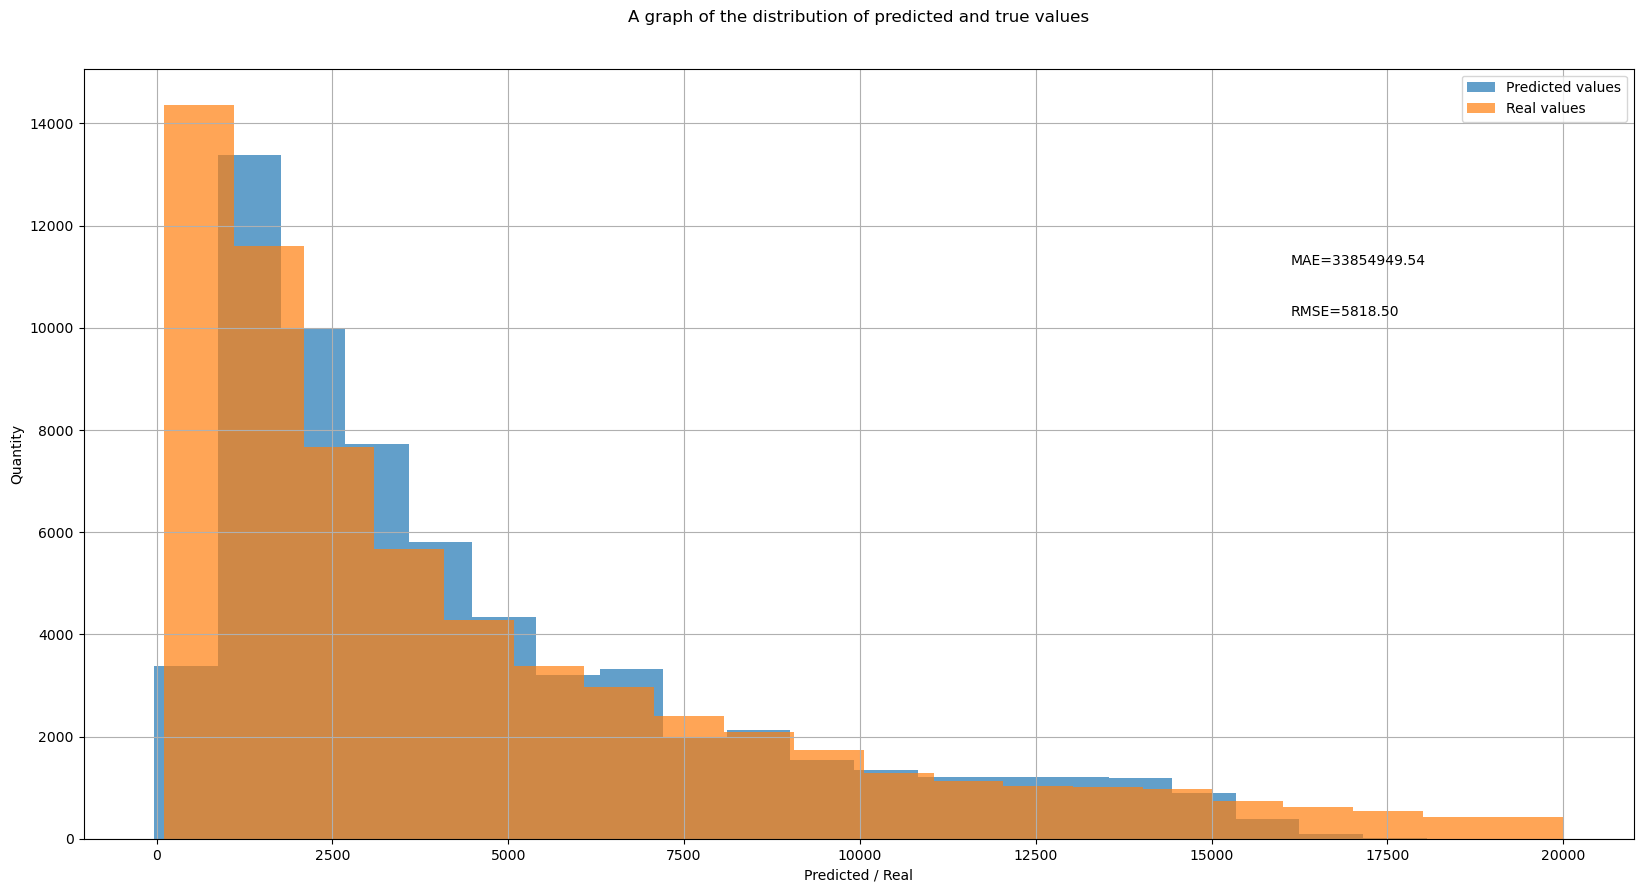

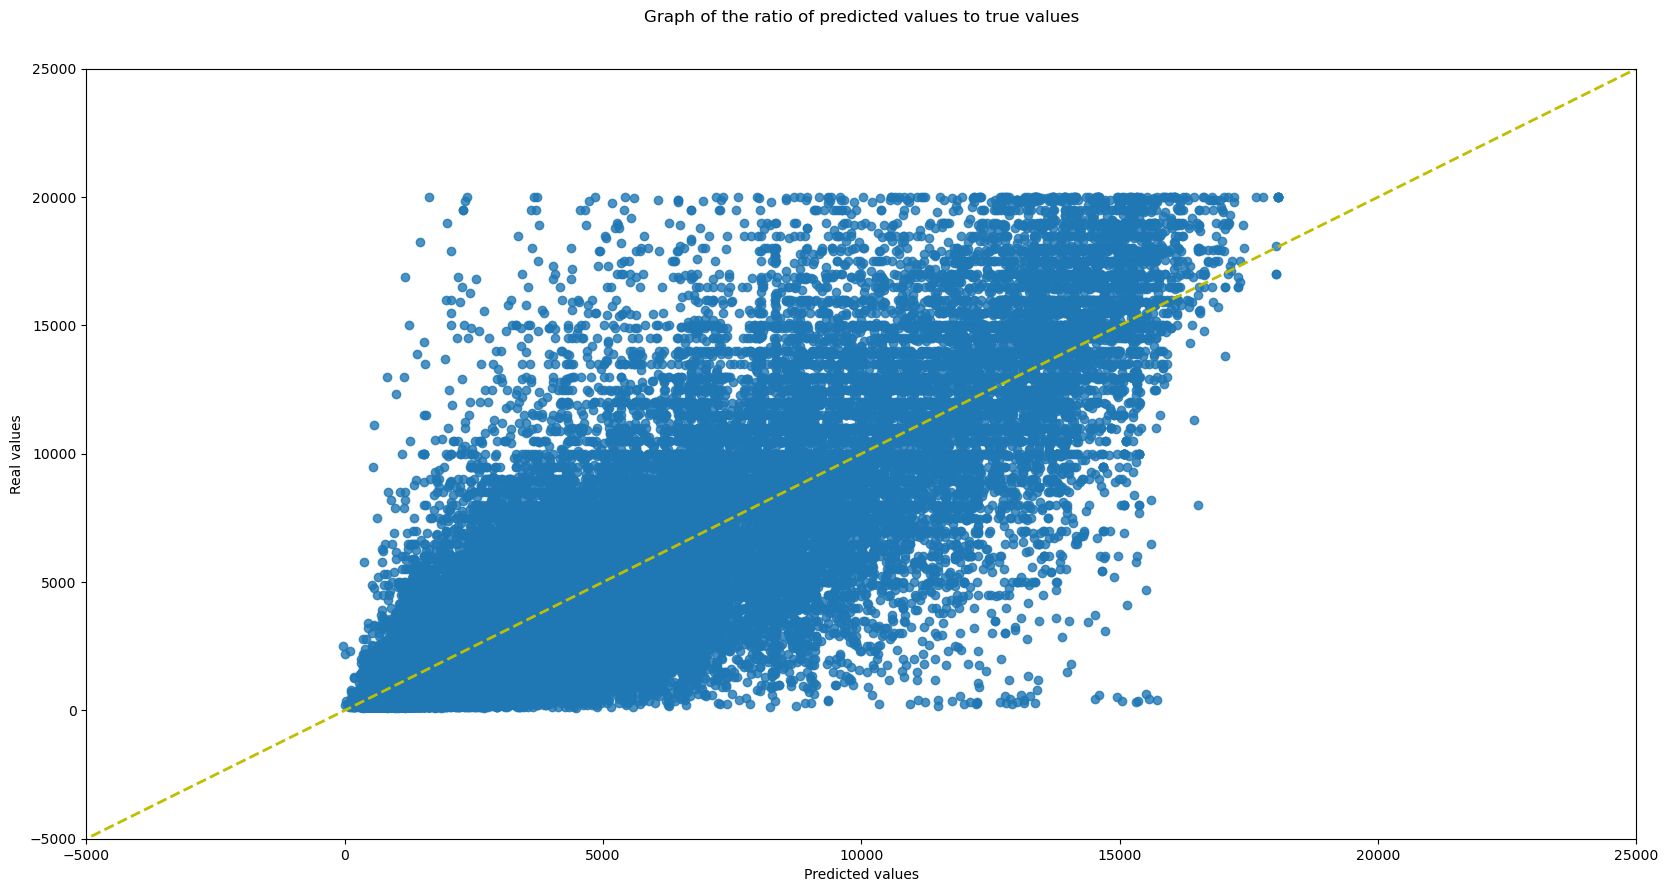

In [75]:
graphics(y_val,pred_lgbm)

In [56]:
clf_cb = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("regressor", CatBoostRegressor(random_state=3,silent=True))]
)

In [57]:
clf_cb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Power', 'Kilometer']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(dtype=<class 'numpy.int8'>))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x00000267236F8650>)])

In [71]:
print("Model evaluation: %.3f" % clf_cb.score(X_val, y_val))

Model evaluation: 0.749


Cut Boost still shows better results than LGBM, although the difference is not very big.

In [59]:
pred_cb=clf_cb.predict(X_val)

In [60]:
%%time
MSE = np.square(np.subtract(y_val, pred_cb)).mean() 
RMSE_CB = math.sqrt(MSE) 
print("RMSE_CB: ", RMSE_CB)

RMSE_CB:  2253.644609173142
CPU times: total: 0 ns
Wall time: 1.99 ms


In [61]:
cat_boost = [2253, '2.42 ms', '2.37 ms']

At the speed level, CatBoost also wins by a small margin.

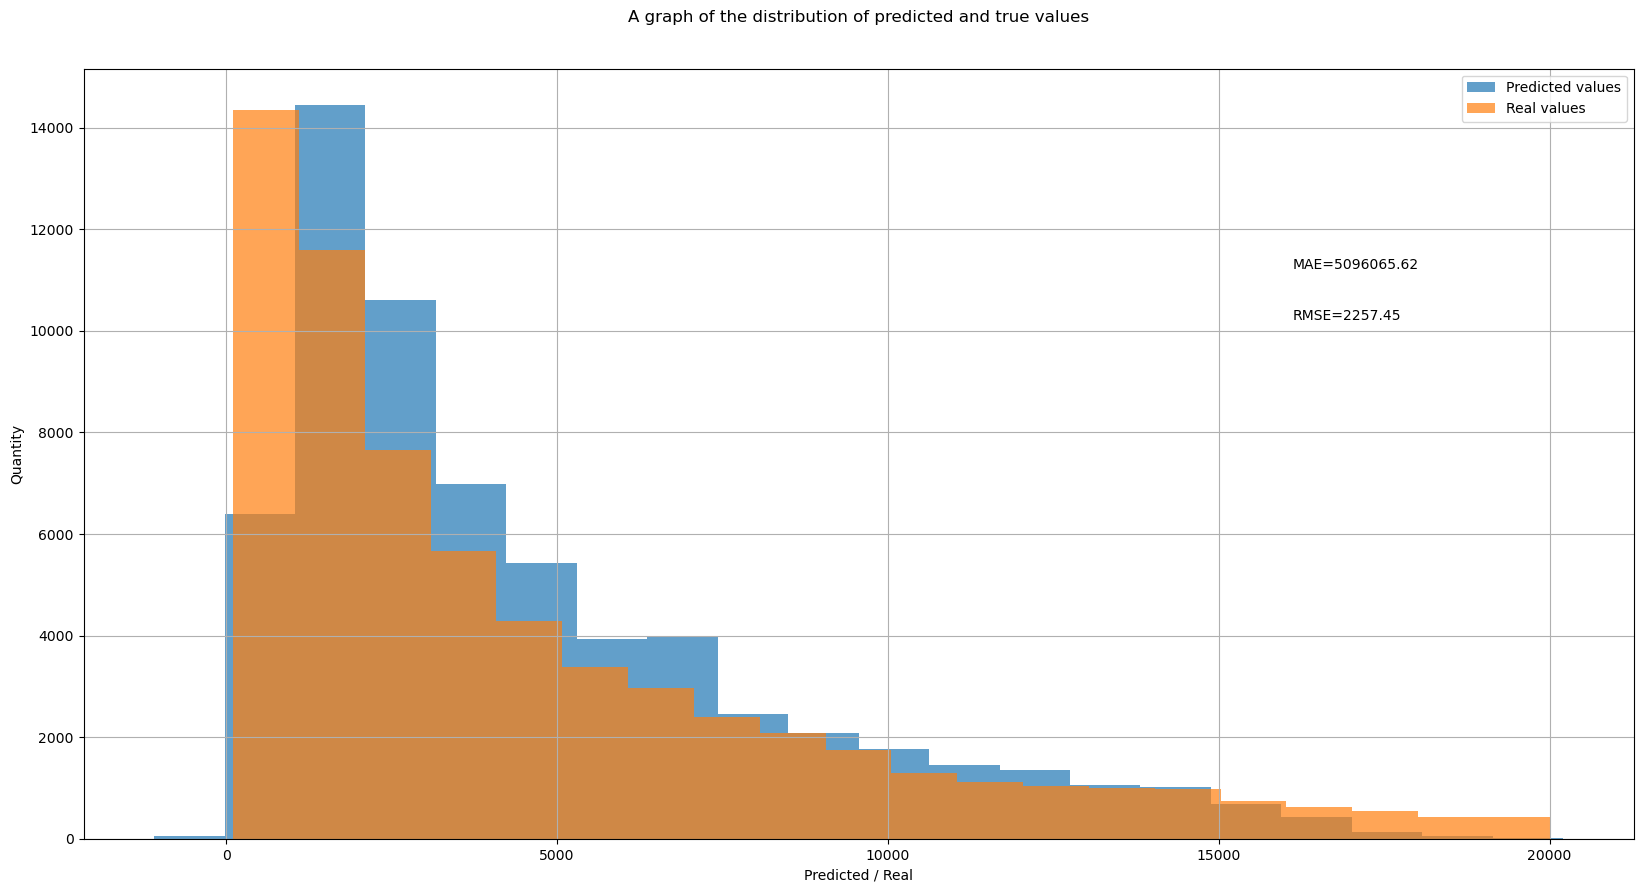

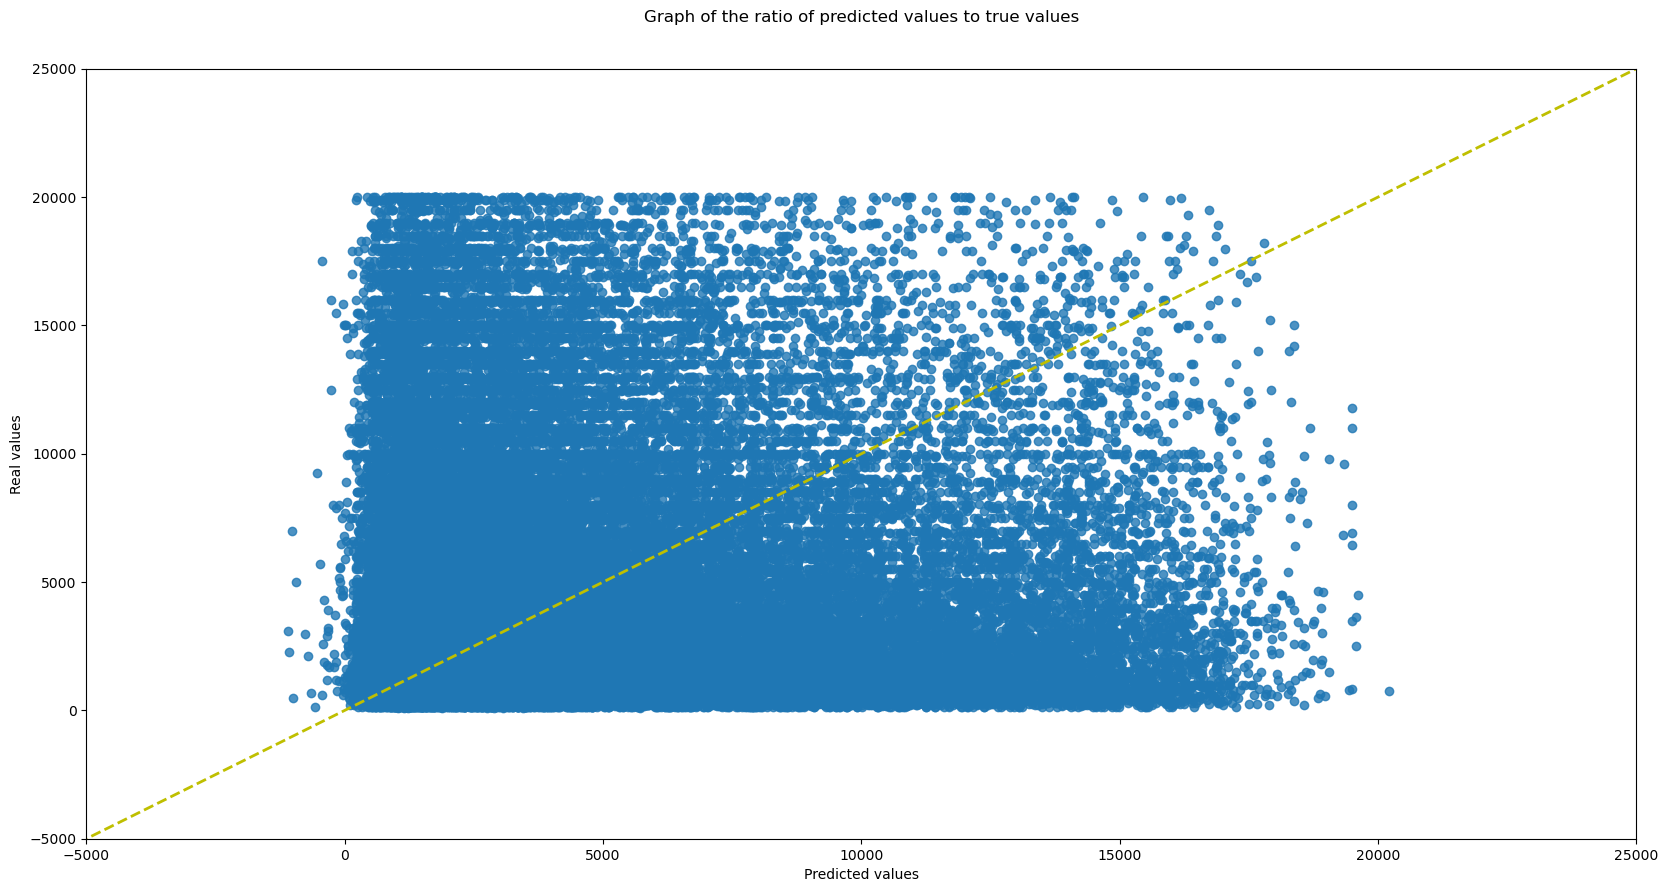

In [76]:
graphics(y_val,pred_cb)

## Model analysis

In [72]:
analysis = pd.DataFrame([random_forest_regressor, LGBM, cat_boost], 
             columns=['RMSE training sample', 'Training time', 'Prediction time'], 
                      index=['Random Forest Regressor', 'LGBM', 'Cat Boost'])    

analysis.sort_values(by='RMSE training sample', ascending=True)


,RMSE training sample,Training time,Prediction time
Cat Boost,2253,2.42 ms,2.37 ms
LGBM,2370,15.7 ms,1.55 ms
Random Forest Regressor,3531,2.84 ms,1.75 ms


## Testing the best model

The best model turned out to be the Cat Boost model, so that's what we're going to test at the final stage of testing. 

In [64]:
%%time
pred_cb=clf_cb.predict(X_test)
MSE = np.square(np.subtract(y_test, pred_cb)).mean() 
RMSE_CB = math.sqrt(MSE) 
print("RMSE_CB: ", RMSE_CB)

RMSE_CB:  2257.446702663042
CPU times: total: 234 ms
Wall time: 208 ms


As we can see, the RMSE is very similar to the one obtained at the validation stage, and the time is slightly longer than it was obtained at the validation stage, but even in this case we can call it fast.

### Conclusions
As we can see from the final output, the most recommended model for predicting the price according to the customer's request-the speed of deployment - is CatBoost.
Both CatBoost and LGBM are better regression solutions than the RandomForestRegressor model, these gradient boosting models show results twice as good.
At the predictive level, the tree model also does not work well, since both the LGBM model and the CatBoost model, the predictive results are closer to the real results, as we see in the visualization graphs. Nevertheless, as a winner in the field of forecasting, LGBM performs better than CatBoost, since its results are closer to real data. As for speed, the clear winner is also the CatBoost model.